<a href="https://colab.research.google.com/github/kahmengg/data-mining-project/blob/main/Copy_Group8_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !sudo apt update
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# #Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# !wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# !tar xf spark-3.2.1-bin-hadoop3.2.tgz
# !pip install -q findspark
# !pip install pyspark
# !pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
# Initialize findspark
import findspark
findspark.init()
findspark.find()


'/usr/local/lib/python3.10/dist-packages/pyspark'

In [ ]:

# LOAD PYSPARK LIBRARIES
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import when

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCols, HasOutputCols
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.functions import col, udf, regexp_extract, mean
from pyspark.sql.types import DoubleType, IntegerType, FloatType
from pyspark.sql.functions import count, when, isnan, col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import StringType

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re


In [ ]:
drive.mount("/content/drive")

test_df = spark.read.csv("/content/drive/MyDrive/Dataset/test.csv", header=True, inferSchema=True)
train_df = spark.read.csv("/content/drive/MyDrive/Dataset/train.csv", header=True, inferSchema=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#DATA DISCOVERY / VISUALIZATION

In [ ]:
# show first few rows of dataset
train_df.printSchema()
train_df.show(10)

root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: string (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: integer (nullable = true)
 |-- Num_of_Loan: string (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: string (nullable = true)
 |-- Changed_Credit_Limit: string (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: string (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: string (nullable = true

In [ ]:
# Summary statistics
train_df.describe().show()

+-------+-------+-----------+------+------+------------------+-----------+----------+------------------+---------------------+-----------------+------------------+------------------+------------------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+------------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+--------------------+------------+
|summary|     ID|Customer_ID| Month|  Name|               Age|        SSN|Occupation|     Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|   Num_Credit_Card|     Interest_Rate|       Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|  Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|     Monthly_Balance|Cred

DROP UNIMPORTANT COLUMNS

In [ ]:
# Drop columns that does not affect Credit Score

drop_df = train_df.drop("ID","SSN", "Monthly_Inhand_Salary","Name","Customer_ID","Month","Num_Bank_Accounts"
,"Num_Credit_Card","Interest_Rate","Num_of_Loan","Type_of_Loan","Changed_Credit_Limit"
,"Num_Credit_Inquiries","Credit_Mix", "Amount_invested_monthly",
         "Credit_Utilization_Ratio")
drop_df.show()

+----+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
| Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+----+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
|  23| Scientist|     19114.12|                  3|                     7|          809.98|22 Years and 1 Mo...|                   No|  49.57494921489417|High_spent_Small_...|312.49408867943663|        Good|
|  23| Scientist|     19114.12|                 -1|                  NULL|          809.98|                  NA|                   No|  49.57494921489417|Low_spent_Larg

Check null values

In [ ]:
# Check for any missing values
drop_df.select([count(when(col(c).isNull() | (col(c) == 'NA'), c)).alias(c) for c in drop_df.columns]).show()

+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+---------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Payment_Behaviour|Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+---------------+------------+
|  0|         0|            0|                  0|                  7002|               0|              9030|                    0|                  0|                0|           1200|           0|
+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+---------------+------------+



#AGE

In [ ]:
# Define the UDF (User Defined Function) to extract numeric values
def extract_numeric(value):
    match = re.search(r'\d+', str(value))
    if match:
        return int(match.group())
    else:
        return None

# Register the UDF with Spark
extract_numeric_udf = udf(extract_numeric, IntegerType())

# Apply the UDF to the 'Age' column in the DataFrame
df_cleaned = drop_df.withColumn('Age', extract_numeric_udf('Age'))

# Filter out invalid age range
df_cleaned = df_cleaned.filter((df_cleaned['Age'] >= 0) & (df_cleaned['Age'] <= 110))
df_cleaned.show(10)

+---+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
| 23| Scientist|     19114.12|                  3|                     7|          809.98|22 Years and 1 Mo...|                   No|  49.57494921489417|High_spent_Small_...|312.49408867943663|        Good|
| 23| Scientist|     19114.12|                 -1|                  NULL|          809.98|                  NA|                   No|  49.57494921489417|Low_spent_Large_v..

#OCCUPATION

In [ ]:
# Drop rows with '_______'
df_filtered = df_cleaned.filter(df_cleaned["Occupation"] != "_______")

# StringIndexer to encode the categorical column
indexer = StringIndexer(inputCol="Occupation", outputCol="OccupationIndex")

# Fit and transform the indexer on the filtered DataFrame
indexer_model = indexer.fit(df_filtered)
df_filtered = indexer_model.transform(df_filtered)

# Update the existing 'Occupation' column with the encoded values
df_cleaned = df_filtered.withColumn("Occupation", col("OccupationIndex").cast("int")).drop("OccupationIndex")


# Show the resulting DataFrame
df_cleaned.show(10)

+---+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
| 23|         3|     19114.12|                  3|                     7|          809.98|22 Years and 1 Mo...|                   No|  49.57494921489417|High_spent_Small_...|312.49408867943663|        Good|
| 23|         3|     19114.12|                 -1|                  NULL|          809.98|                  NA|                   No|  49.57494921489417|Low_spent_Large_v..

#ANNUAL INCOME

In [ ]:
# Clean the data by removing underscores
df_cleaned = df_cleaned.withColumn("Annual_Income", regexp_replace(df_cleaned["Annual_Income"], "_", "").cast(StringType()))
df_cleaned = df_cleaned.withColumn("Annual_Income", regexp_replace(df_cleaned["Annual_Income"], "_", "").cast(FloatType()))
df_cleaned.show(10)

+---+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
| 23|         3|     19114.12|                  3|                     7|          809.98|22 Years and 1 Mo...|                   No|  49.57494921489417|High_spent_Small_...|312.49408867943663|        Good|
| 23|         3|     19114.12|                 -1|                  NULL|          809.98|                  NA|                   No|  49.57494921489417|Low_spent_Large_v..

#NUM DELAYED PAYMENT

In [ ]:
# Clean the data by removing underscores
df_cleaned = df_cleaned.withColumn("Num_of_Delayed_Payment", regexp_replace(df_cleaned["Num_of_Delayed_Payment"], "_", "").cast(StringType()))
df_cleaned = df_cleaned.withColumn("Num_of_Delayed_Payment", regexp_replace(df_cleaned["Num_of_Delayed_Payment"], "_", "").cast(IntegerType()))
# Calculate the mean
mean_value = df_cleaned.select(mean(col("Num_of_Delayed_Payment"))).collect()[0][0]

# Fill null values with the mean
df_cleaned = df_cleaned.fillna(mean_value, subset=["Num_of_Delayed_Payment"])
df_cleaned.show(10)


+---+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
| 23|         3|     19114.12|                  3|                     7|          809.98|22 Years and 1 Mo...|                   No|  49.57494921489417|High_spent_Small_...|312.49408867943663|        Good|
| 23|         3|     19114.12|                 -1|                    30|          809.98|                  NA|                   No|  49.57494921489417|Low_spent_Large_v..

#OUTSTANDING DEBT

In [ ]:
# Clean the data by removing underscores
df_cleaned = df_cleaned.withColumn("Outstanding_Debt", regexp_replace(df_cleaned["Outstanding_Debt"], "_", "").cast(StringType()))
df_cleaned = df_cleaned.withColumn("Outstanding_Debt", regexp_replace(df_cleaned["Outstanding_Debt"], "_", "").cast(FloatType()))
df_cleaned.show(10)

+---+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+--------------------+---------------------+-------------------+--------------------+------------------+------------+
| 23|         3|     19114.12|                  3|                     7|          809.98|22 Years and 1 Mo...|                   No|  49.57494921489417|High_spent_Small_...|312.49408867943663|        Good|
| 23|         3|     19114.12|                 -1|                    30|          809.98|                  NA|                   No|  49.57494921489417|Low_spent_Large_v..

#CREDIT HISTORY AGE

In [ ]:
# Extract digits from strings
df_cleaned = df_cleaned.withColumn("Credit_History_Age", regexp_extract(col("Credit_History_Age"), r"(\d+)", 1))

# Convert extracted strings to numeric values
df_cleaned = df_cleaned.withColumn("Credit_History_Age", df_cleaned["Credit_History_Age"].cast(IntegerType()))

# Calculate the mean
credit_mean = df_cleaned.select(mean("Credit_History_Age")).collect()[0][0]

# Fill missing values with mean
df_cleaned = df_cleaned.fillna(credit_mean, subset=["Credit_History_Age"])

# Convert to integer type
df_cleaned = df_cleaned.withColumn("Credit_History_Age", col("Credit_History_Age").cast(IntegerType()))

# Show the cleaned DataFrame
df_cleaned.show(10)


+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+--------------------+------------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+--------------------+------------------+------------+
| 23|         3|     19114.12|                  3|                     7|          809.98|                22|                   No|  49.57494921489417|High_spent_Small_...|312.49408867943663|        Good|
| 23|         3|     19114.12|                 -1|                    30|          809.98|                17|                   No|  49.57494921489417|Low_spent_Large_v...|284.6291

In [ ]:
# StringIndexer to encode the categorical column
indexer = StringIndexer(inputCol="Payment_of_Min_Amount", outputCol="Payment_of_Min_AmountIndex")

# Fit and transform the indexer on the filtered DataFrame
indexer_model = indexer.fit(df_cleaned)
df_filtered = indexer_model.transform(df_cleaned)

# Update the existing 'Occupation' column with the encoded values
df_cleaned = df_filtered.withColumn("Payment_of_Min_Amount", col("Payment_of_Min_AmountIndex").cast("int")).drop("Payment_of_Min_AmountIndex")

# Show the resulting Data
df_cleaned.show(10)

+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+--------------------+------------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+--------------------+------------------+------------+
| 23|         3|     19114.12|                  3|                     7|          809.98|                22|                    1|  49.57494921489417|High_spent_Small_...|312.49408867943663|        Good|
| 23|         3|     19114.12|                 -1|                    30|          809.98|                17|                    1|  49.57494921489417|Low_spent_Large_v...|284.6291

#PAYMENT BEHAVIOUR

In [ ]:
# Drop rows with '_______'
df_filtered = df_cleaned.filter(df_cleaned["Payment_Behaviour"] != "!@9#%8")

# StringIndexer to encode the categorical column
indexer = StringIndexer(inputCol="Payment_Behaviour", outputCol="Payment_BehaviourIndex")

# Fit and transform the indexer on the filtered DataFrame
indexer_model = indexer.fit(df_filtered)
df_filtered = indexer_model.transform(df_filtered)

# Update the existing 'Payment_Behaviour' column with the encoded values
df_cleaned = df_filtered.withColumn("Payment_Behaviour", col("Payment_BehaviourIndex").cast("int")).drop("Payment_BehaviourIndex")


# Show the resulting DataFrame
df_cleaned.show(10)

+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+------------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+------------------+------------+
| 23|         3|     19114.12|                  3|                     7|          809.98|                22|                    1|  49.57494921489417|                4|312.49408867943663|        Good|
| 23|         3|     19114.12|                 -1|                    30|          809.98|                17|                    1|  49.57494921489417|                5|284.62916249607184|    

#MONTHLY BALANCE

In [ ]:
df_cleaned = df_cleaned.withColumn("Monthly_Balance", col("Monthly_Balance").cast("double")).na.drop(subset=["Monthly_Balance"])
df_cleaned.show(10)

+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+------------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+------------------+------------+
| 23|         3|     19114.12|                  3|                     7|          809.98|                22|                    1|  49.57494921489417|                4|312.49408867943663|        Good|
| 23|         3|     19114.12|                 -1|                    30|          809.98|                17|                    1|  49.57494921489417|                5|284.62916249607184|    

Credit Score

In [ ]:
# StringIndexer to encode the categorical column
indexer = StringIndexer(inputCol="Credit_Score", outputCol="Credit_Score_Index")

# Fit and transform the indexer on the filtered DataFrame
indexer_model = indexer.fit(df_cleaned)
df_filtered = indexer_model.transform(df_cleaned)

# Update the existing 'Credit_Score' column with the encoded values
df_cleaned = df_filtered.withColumn("Credit_Score", col("Credit_Score_Index").cast("int")).drop("Credit_Score_Index")

# Show the resulting Data
df_cleaned.show(10)

+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+------------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+------------------+------------+
| 23|         3|     19114.12|                  3|                     7|          809.98|                22|                    1|  49.57494921489417|                4|312.49408867943663|           2|
| 23|         3|     19114.12|                 -1|                    30|          809.98|                17|                    1|  49.57494921489417|                5|284.62916249607184|    

Final Check

In [ ]:
# Check for any missing values or null
df_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

unique_values = {}

# Loop through each column
for column in df_cleaned.columns:
    # Collect unique values for the column
    unique_values[column] = df_cleaned.select(column).distinct().collect()

# Print unique values
for column, values in unique_values.items():
    print(f"Unique values for column '{column}': {[row[column] for row in values]}")

+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+---------------+------------+
|Age|Occupation|Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment|Outstanding_Debt|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Payment_Behaviour|Monthly_Balance|Credit_Score|
+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+---------------+------------+
|  0|         0|            0|                  0|                     0|               0|                 0|                    0|                  0|                0|              0|           0|
+---+----------+-------------+-------------------+----------------------+----------------+------------------+---------------------+-------------------+-----------------+---------------+------------+

Uniq

# Prepare Data

In [ ]:
drop_df = df_cleaned.toPandas()

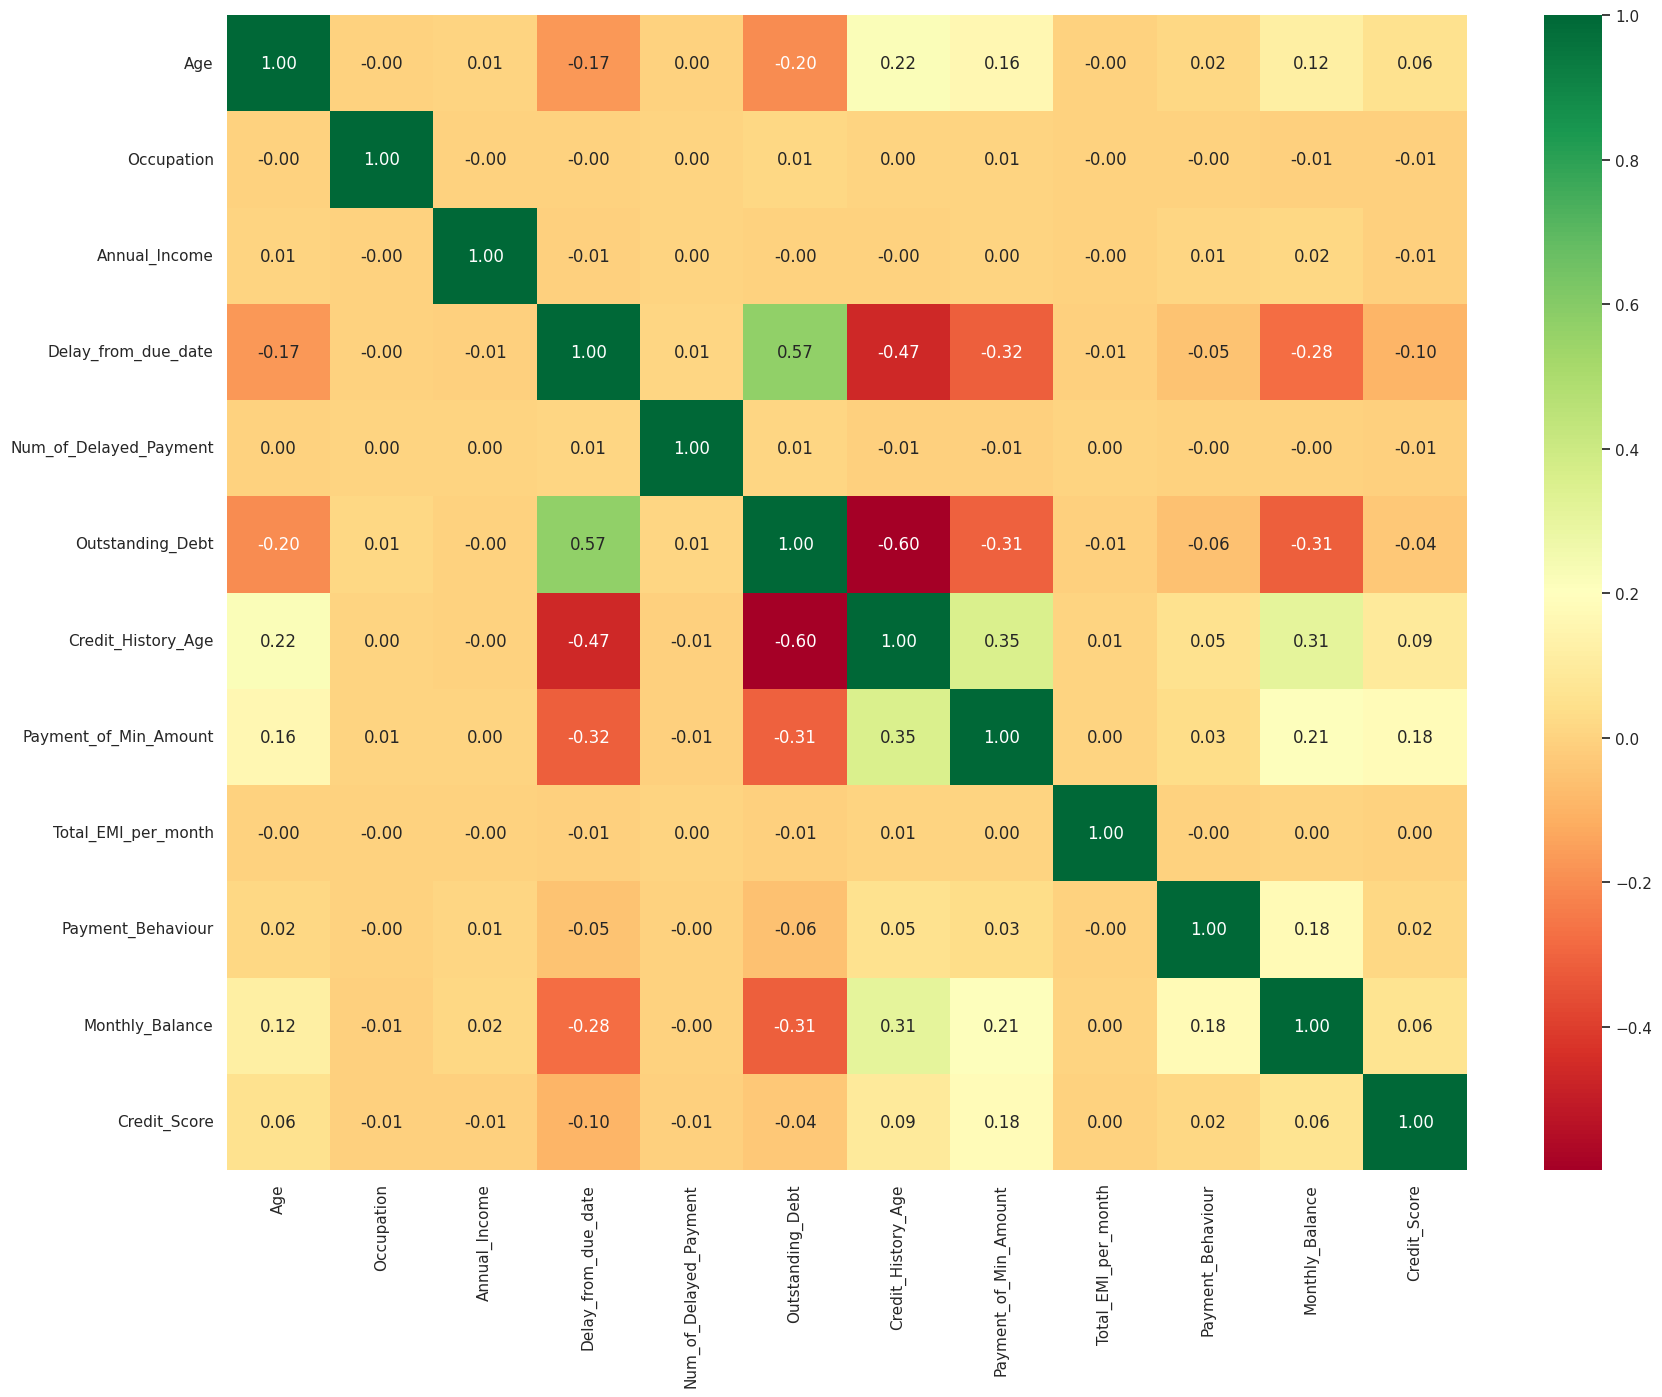

In [ ]:
cr=drop_df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(cr,annot=True,fmt=".2f",cmap="RdYlGn")
plt.show()

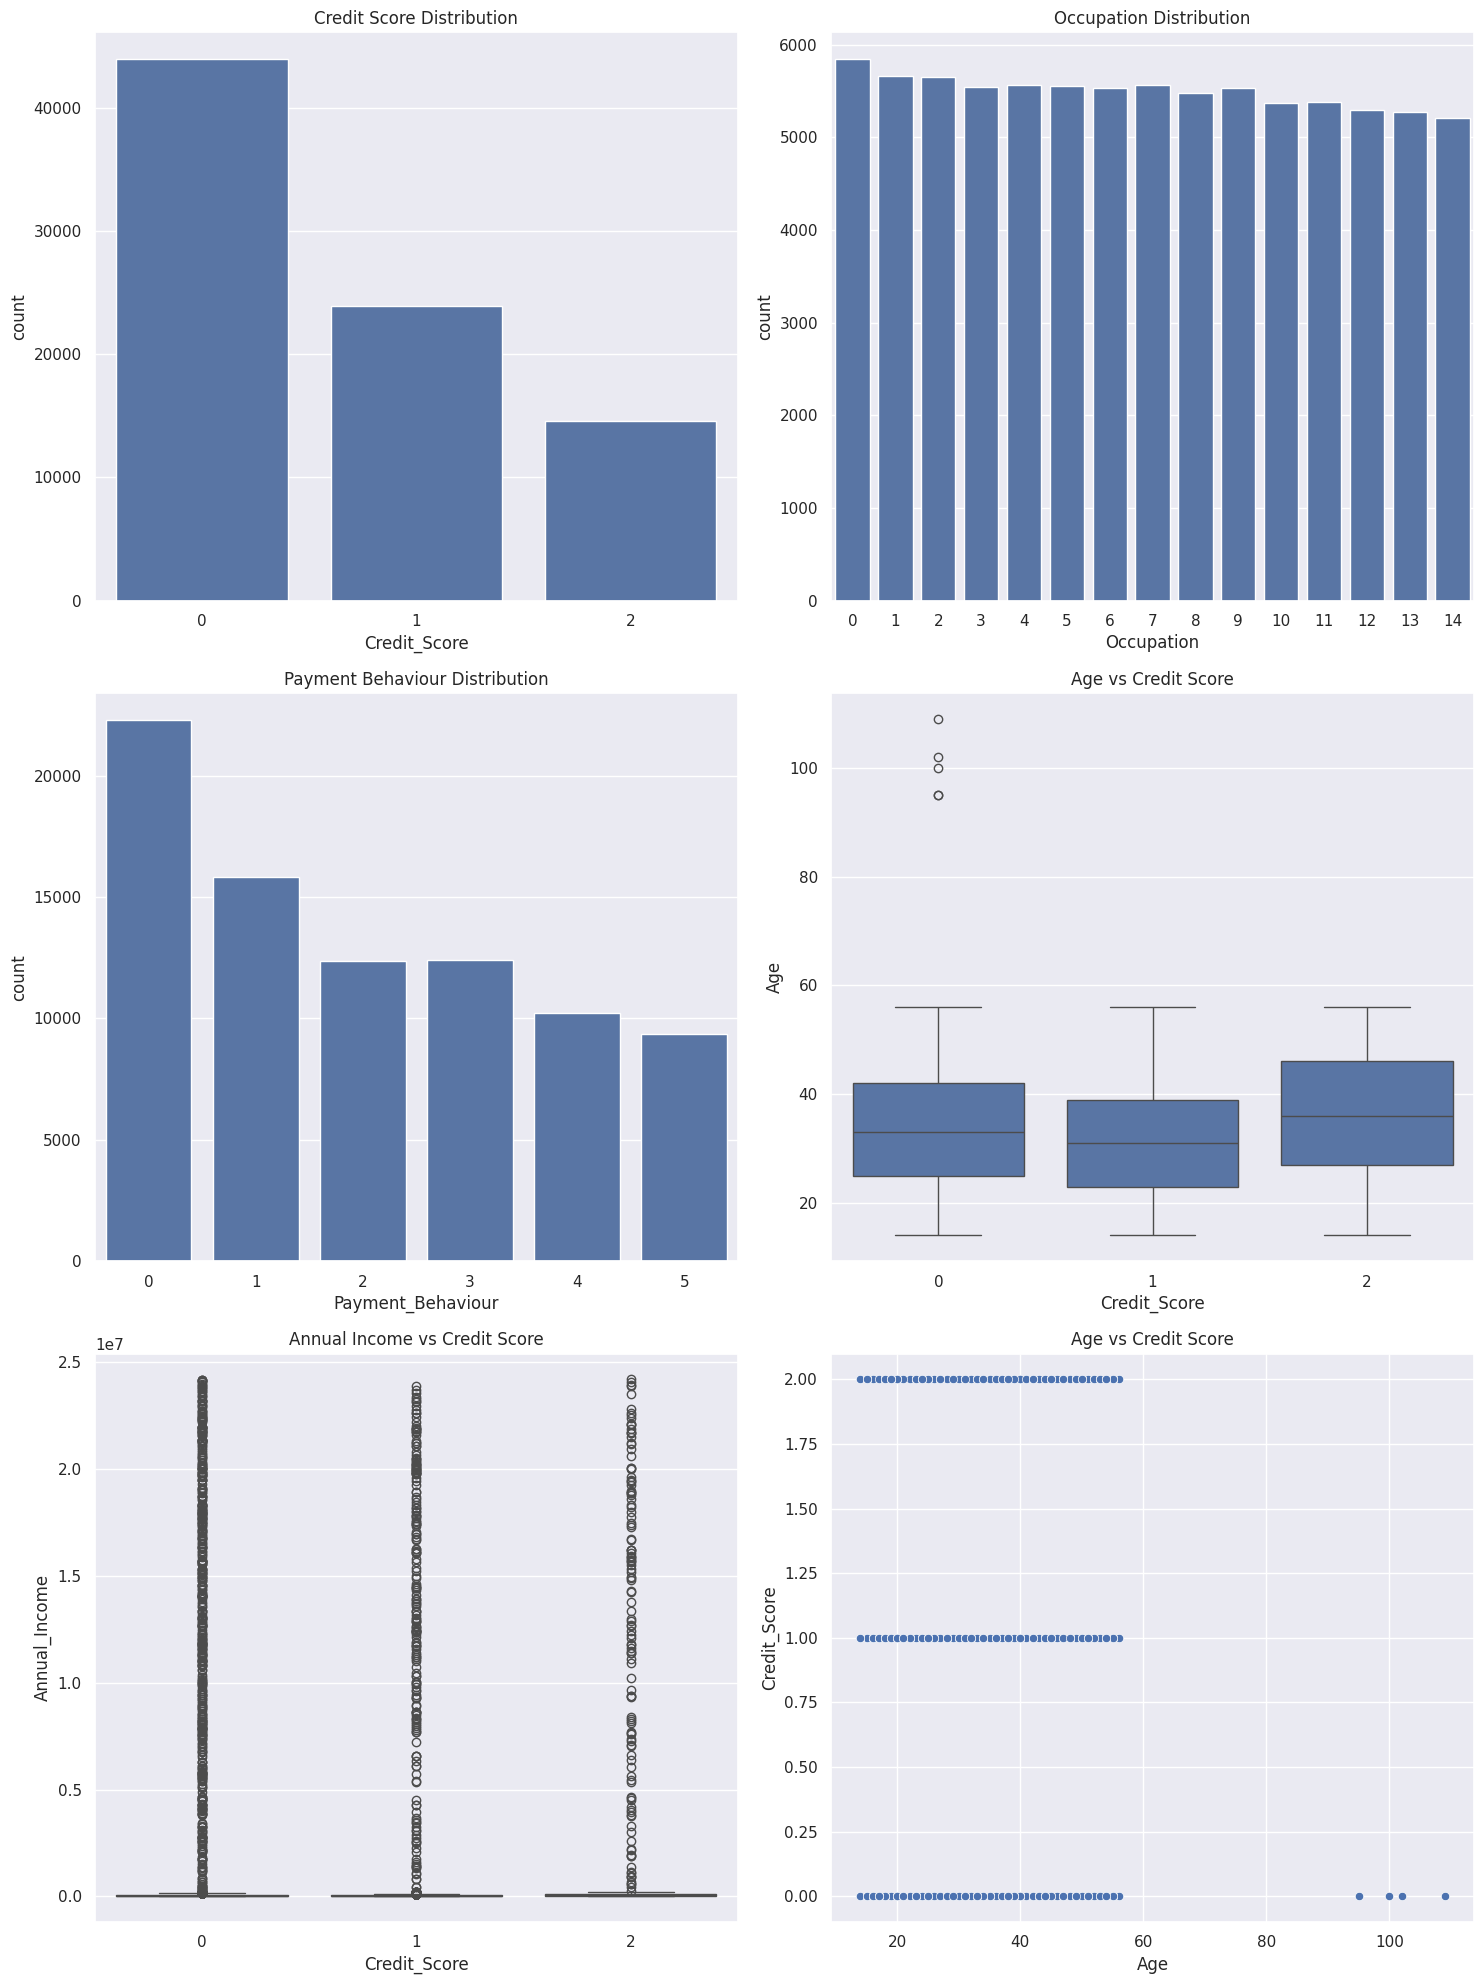

In [ ]:
sns.set()
fig, axes = plt.subplots(3, 2, figsize=(15, 20))

# Create plots
sns.countplot(data=drop_df, x='Credit_Score', ax=axes[0, 0])
sns.countplot(data=drop_df, x='Occupation', ax=axes[0, 1])
sns.countplot(data=drop_df, x='Payment_Behaviour', ax=axes[1, 0])

sns.boxplot(data=drop_df, x='Credit_Score', y='Age', ax=axes[1, 1])
sns.boxplot(data=drop_df, x='Credit_Score', y='Annual_Income', ax=axes[2, 0])

sns.scatterplot(data=drop_df, x='Age', y='Credit_Score', ax=axes[2, 1])

# Add titles
axes[0, 0].set_title('Credit Score Distribution')
axes[0, 1].set_title('Occupation Distribution')
axes[1, 0].set_title('Payment Behaviour Distribution')
axes[1, 1].set_title('Age vs Credit Score')
axes[2, 0].set_title('Annual Income vs Credit Score')
axes[2, 1].set_title('Age vs Credit Score')

plt.tight_layout()
plt.show()


In [ ]:
spark_df = spark.createDataFrame(drop_df)
spark_df.show()


+---+----------+---------------+-------------------+----------------------+-----------------+------------------+---------------------+-------------------+-----------------+------------------+------------+
|Age|Occupation|  Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment| Outstanding_Debt|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+----------+---------------+-------------------+----------------------+-----------------+------------------+---------------------+-------------------+-----------------+------------------+------------+
| 23|         3|19114.119140625|                  3|                     7|  809.97998046875|                22|                    1|  49.57494921489417|                4|312.49408867943663|           2|
| 23|         3|19114.119140625|                 -1|                    30|  809.97998046875|                17|                    1|  49.57494921489417|                5|284.6291

In [ ]:
def stratified_split(df, feature, train_frac):
    # Compute the fractions for each category in the specified feature
    fractions = df.groupBy(feature).count().withColumnRenamed('count', 'count_label')
    fractions = fractions.withColumn('fraction', fractions['count_label'] / df.count())

    # Collect the fractions as a dictionary
    fractions_dict = fractions.select(feature, 'fraction').rdd.collectAsMap()

    # Perform stratified sampling
    training_data = df.stat.sampleBy(feature, fractions=fractions_dict, seed=42)
    testing_data = df.subtract(training_data)
    (training_data, testing_data) = df.randomSplit([0.8, 0.2], seed=42)
    # Split the data into training and testing sets
    return training_data, testing_data

In [ ]:
train_data, test_data = stratified_split(spark_df, 'Credit_Score', 0.8)

# Logistic Reg


In [ ]:
def standard_model():
  # Vector Assembly
  inputCols = spark_df.columns[:-1]
  assembler = VectorAssembler(inputCols=inputCols, outputCol="assembled_features")
  standard_spark_df = assembler.transform(spark_df)

  # Train Split
  train_data, test_data =stratified_split(standard_spark_df, 'Credit_Score', 0.8)
  lr = LogisticRegression(labelCol="Credit_Score", featuresCol="assembled_features", maxIter=10)
  lr_model = lr.fit(train_data)

  # Make predictions on the testing data
  predictions = lr_model.transform(test_data)

  # Evaluate the standard model's accuracy
  evaluator = MulticlassClassificationEvaluator(labelCol="Credit_Score", metricName="accuracy")
  accuracy = evaluator.evaluate(predictions)
  print('Accuracy: ',accuracy)
standard_model()

Accuracy:  0.5681373747250061


Feature Scaling

In [ ]:
# List of feature columns to be scaled
def feature_engineering(spark_df):

    # Splitting the data into training and testing sets
    train_data, test_data = stratified_split(spark_df, 'Credit_Score', 0.8)

    # Define the VectorAssembler to assemble features
    inputCols = spark_df.columns[:-1]
    assembler = VectorAssembler(inputCols=inputCols, outputCol="assembled_features")
    spark_df_with_features = assembler.transform(spark_df)

    # Feature Scaling
    scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features", withStd=True, withMean=True)

    # Define the pipeline
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fit the pipeline on the training data
    pipeline_model = pipeline.fit(train_data)

    # Transform the training data
    scaled_train_df = pipeline_model.transform(train_data)

    # Transform the testing data
    scaled_test_df = pipeline_model.transform(test_data)

    # Drop the original assembled_features column from both datasets
    scaled_train_df = scaled_train_df.drop('assembled_features')
    scaled_test_df = scaled_test_df.drop('assembled_features')

    return scaled_train_df,scaled_test_df


Feature Scaled Model

In [ ]:
scaled_train_df,scaled_test_df = feature_engineering(spark_df)

In [ ]:
# Train a multinomial logistic regression model on the training data
lr = LogisticRegression(labelCol="Credit_Score", featuresCol="scaled_features", maxIter=10)
lr_model = lr.fit(scaled_train_df)

# Make predictions on the testing data
predictions = lr_model.transform(scaled_test_df)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Credit_Score", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [ ]:
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='accuracy').evaluate(predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='weightedPrecision').evaluate(predictions))
print('Recall: ',MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='weightedRecall').evaluate(predictions))
print('F1-score: ',MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='f1').evaluate(predictions))

Accuracy:  0.5681373747250061
Precision:  0.5570398009258211
Recall:  0.5681373747250061
F1-score:  0.5378889637308484


Hyperparameter Fine Tuning
- Cross Validation to avoid overfitting
- Find best parameters for logistic regression

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
lr = LogisticRegression(labelCol="Credit_Score", featuresCol="scaled_features", maxIter=10, family="multinomial")

# Define parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012]) \
    .addGrid(lr.elasticNetParam, [0.43, 0.44, 0.45, 0.46, 0.47]) \
    .addGrid(lr.threshold, [0.3, 0.4, 0.5]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .build()

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Credit_Score", metricName="accuracy")

# Define cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=2)

# Run cross-validation to find the best hyperparameters
cv_model = crossval.fit(scaled_train_df)

# Get the best hyperparameters
best_model = cv_model.bestModel
best_reg_param = best_model._java_obj.getRegParam()
best_elastic_net_param = best_model._java_obj.getElasticNetParam()
best_threshold = best_model._java_obj.getThreshold()  # Example of retrieving the best threshold
best_fit_intercept = best_model._java_obj.getFitIntercept()  # Example of retrieving the best fitIntercept

print("Best regParam : ", best_reg_param)
print("Best elasticNetParam : ", best_elastic_net_param)
print("Best threshold: ", best_threshold)
print("Best fitIntercept: ", best_fit_intercept)

# Train the model with the best hyperparameters on the entire training set
best_lr_model = lr.setRegParam(best_reg_param) \
  .setElasticNetParam(best_elastic_net_param) \
  .setThreshold(best_threshold) \
  .setFitIntercept(best_fit_intercept) \
  .fit(scaled_train_df)

# Make predictions on the testing data
predictions = best_lr_model.transform(scaled_test_df)

# Evaluate the model's accuracy on the test data
# print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='accuracy').evaluate(predictions))
# print('Precision: ',MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='weightedPrecision').evaluate(predictions))
# print('Recall: ',MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='weightedRecall').evaluate(predictions))
# print('F1-score: ',MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='f1').evaluate(predictions))

Best regParam :  0.005
Best elasticNetParam :  0.46
Best threshold:  0.3
Best fitIntercept:  True


Create more informative features

In [ ]:
from pyspark.ml import Transformer
class FeatureCreator(Transformer):
    def _transform(self, dataset):
        # Define UDFs for new feature creation
        debt_to_income_udf = udf(lambda outstanding_debt, annual_income: outstanding_debt / annual_income, DoubleType())
        age_credit_score_udf = udf(lambda age, credit_score: age * credit_score)

        # Create new columns with the calculated features
        new_dataset = dataset.withColumn("Debt_To_Income_Ratio", debt_to_income_udf(col('Outstanding_Debt'), col('Annual_Income')))
        new_dataset = new_dataset.withColumn("Age_Credit_Score_Interaction", age_credit_score_udf(col('Age'), col('Credit_Score')))
        new_dataset = new_dataset.withColumn("Age_Credit_Score_Interaction", new_dataset["Age_Credit_Score_Interaction"].cast(IntegerType()))

        # Get list of existing columns
        existing_columns = dataset.columns

        # Find the index of the last column (target variable)
        last_index = len(existing_columns) - 1

        # Insert new columns at the second last position
        new_columns = existing_columns[:-1] + ["Debt_To_Income_Ratio", "Age_Credit_Score_Interaction"] + [existing_columns[-1]]

        # Reorder columns in the DataFrame
        new_dataset = new_dataset.select(*new_columns)

        return new_dataset

# Initialize the custom transformer
feature_creator = FeatureCreator()


In [ ]:
# Transform your data
new_spark_df = spark.createDataFrame(drop_df)

transformed_data = feature_creator.transform(new_spark_df)


new_train_data,new_test_data = feature_engineering(transformed_data)

transformed_data.show()

+---+----------+---------------+-------------------+----------------------+-----------------+------------------+---------------------+-------------------+-----------------+------------------+--------------------+----------------------------+------------+
|Age|Occupation|  Annual_Income|Delay_from_due_date|Num_of_Delayed_Payment| Outstanding_Debt|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Payment_Behaviour|   Monthly_Balance|Debt_To_Income_Ratio|Age_Credit_Score_Interaction|Credit_Score|
+---+----------+---------------+-------------------+----------------------+-----------------+------------------+---------------------+-------------------+-----------------+------------------+--------------------+----------------------------+------------+
| 23|         3|19114.119140625|                  3|                     7|  809.97998046875|                22|                    1|  49.57494921489417|                4|312.49408867943663|  0.0423760035453177|                       

In [ ]:

lr = LogisticRegression(featuresCol='scaled_features',labelCol="Credit_Score")

# DEFINE GRID PARAMETERS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.05,0.01,0.05, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.45,0.75))\
                              .build()

# DEFINE CROSS VALIDATION WITH PARAMETERS
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Credit_Score')
                           ,trainRatio=0.8)
model = tvs.fit(new_train_data)
model_predictions= model.transform(new_test_data)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ',MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='weightedRecall').evaluate(model_predictions))
print('F1-score: ',MulticlassClassificationEvaluator(labelCol='Credit_Score',metricName='f1').evaluate(model_predictions))

Accuracy:  0.9961500855536544
Precision:  0.9962001670341663
Recall:  0.9961500855536543
F1-score:  0.9961413183231548
